# LSTM

In [1]:
# util.py has pmdarima function inside
# Need to install it before import the pyfile
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.1MB/s 
     |████████████████████████████████| 9.5MB 19.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pickle import dump, load

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Keras, Tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

## Goole Colab Setup

In [3]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
# Get the current working directory
print(os.getcwd())

/content


In [5]:
# Drive path is the path where I upload the ETFs history file and pre-written pyfile
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'

# Expect to move these file into the local path
local_path = '/content'

In [6]:
# Copy these file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .

# Change these file from drive path to the local path
os.chdir(local_path)

In [7]:
# Pre-written function
import util as ut

## Preprocesing

In [8]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [9]:
# Select one REIT ETF
vnq = data.copy().loc[data['Ticker'] == "VNQ"]

In [10]:
# Preprocess the dataframe
ut.preprocess_df(vnq)

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...
2021-06-17,103.410004,103.699997,102.860001,103.550003,5055100,0.0,0.0,VNQ
2021-06-18,103.019997,103.470001,101.790001,101.790001,5358000,0.0,0.0,VNQ
2021-06-21,102.309998,104.209999,101.800003,103.889999,3672900,0.0,0.0,VNQ


In [11]:
# Split the data into train, validation, and test set
# Test size = 1 month (22 days)
# Val size = 1 year (253 days)
# Train size = rest of the time
train = vnq['Close'].iloc[:-275]
val = vnq['Close'].iloc[-275:-22]
test = vnq['Close'].iloc[-22:]

In [12]:
print("Train: date from {} to {}, total of {} days".format(train.index[0],train.index[-1], len(train)))
print("Val: date from {} to {}, total of {} days".format(val.index[0],val.index[-1], len(val)))
print("Test: date from {} to {}, total of {} days".format(test.index[0],test.index[-1], len(test)))

Train: date from 2004-09-29 00:00:00 to 2020-05-20 00:00:00, total of 3938 days
Val: date from 2020-05-21 00:00:00 to 2021-05-21 00:00:00, total of 253 days
Test: date from 2021-05-24 00:00:00 to 2021-06-23 00:00:00, total of 22 days


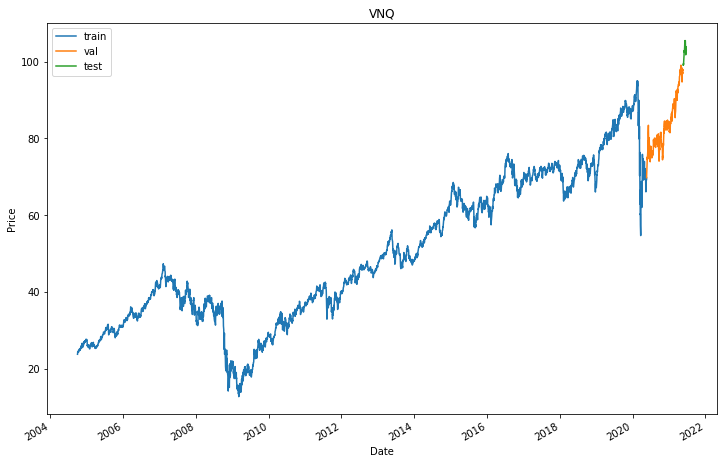

In [13]:
plt.figure(figsize=(12,8))
train.plot()
val.plot()
test.plot()
plt.title("VNQ")
plt.ylabel("Price")
plt.legend(['train', 'val', 'test'])
plt.show()

In [14]:
# Scale the data
scaler = MinMaxScaler()

train_scale = scaler.fit_transform(train.values.reshape(-1,1))
val_scale = scaler.transform(val.values.reshape(-1,1))
test_scale = scaler.transform(test.values.reshape(-1,1))

In [15]:
# Save the scaler (for future use)
dump(scaler, open('/content/scaler.pkl', 'wb'))

# Load the scaler (if run in another notebook)
# sc = load(open('/content/scaler.pkl', 'rb'))

In [16]:
def xy_split (dataset, timestep):
    '''
    Split the time series into X and y part based on the number of timestep.
    Ex. Use n days to predict the next preceding day (n+1) price.
    
    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - dataset: Time series data
    - timestep: number of days in integer
    
    Return: 
    - X_part, y_part (in arrays)
    '''
    
    X_part, y_part = [], []
    
    for i in range(len(dataset)-timestep-1):
         
        X_part.append(dataset[i:(i+timestep)])

        y_part.append(dataset[i+timestep])

    return np.array(X_part), np.array(y_part)

## Modeling

In [17]:
def model_evaluation(model, X_train, y_train, X_val, y_val):
    '''
    Evaluate the LSTM model by using  prediction of y based on X.
    Inverse transform both the prediction y and actual y. 
    
    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - model: Time series model name
    - X_train, y_train, X_val, y_val
    
    Outpus:
    - Evalution results for true y and predicted y
        - MAE, RMSE, and R^2
    
    Return:
    - y_val_true, y_val_inv

    '''
    
    # Make prediction
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Inverse transform the prediction and actual
    y_train_inv = scaler.inverse_transform(y_train_pred) # prediction
    y_val_inv = scaler.inverse_transform(y_val_pred) # prediction

    y_train_true = scaler.inverse_transform(y_train) # actual
    y_val_true =scaler.inverse_transform(y_val) # actual
    
    # Use the evalute function from util pyfile
    print("Train results: ")
    print(ut.evaluate(y_train_true, y_train_inv))
    print("\n")
    print("Val results: ")
    print(ut.evaluate(y_val_true, y_val_inv))

    return y_val_true, y_val_inv

In [18]:
def plot_prediction(y_true, y_pred):
    '''
    Comparison plot of actual y and predicted y.

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    
    Inputs:
    - y_true, y_pred: true y and predicted y
    
    Outpus:
    - Scatter plot of true y and line plot of predicted y
    '''

    plt.figure(figsize=(20,10))
    plt.plot(y_true, '.')
    plt.plot(y_pred)
    plt.legend(['Actual', 'Predicted'])
    plt.show()

### Baseline Model

In [19]:
# X,y split with timestep of 1
X_train, y_train = xy_split(train_scale, timestep=1)
X_val, y_val = xy_split(val_scale, timestep=1)
X_test, y_test = xy_split(test_scale, timestep=1)

In [20]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (3936, 1, 1)
y_train shape:  (3936, 1)
X_val shape:  (251, 1, 1)
y_val shape:  (251, 1)
X_test shape:  (20, 1, 1)
y_test shape:  (20, 1)


https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM

### Early Stopping

In [65]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)  # early stopping when MSE reaches minimum

In [24]:
# Build the model
base_model = Sequential()
base_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:])))
base_model.add(LSTM(50))
base_model.add(Dense(units=1))

# Compile the model
base_model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Model Checkpoint
mc_base = ModelCheckpoint(filepath='/content/t1_u50.h5',
                     monitor='val_loss', mode='min', verbose=0, save_best_only=True)

In [27]:
# Fit the model
base_model.fit(X_train, y_train, batch_size=23, epochs=50,
               validation_data=(X_val, y_val),
               callbacks=[es, mc_base],
               verbose=0)

In [28]:
base_y_val_true, base_y_val_inv = model_evaluation(base_model, X_train, y_train, X_val, y_val)

Train results: 
MAE: 0.4891
RMSE: 0.7551
R^2: 0.9984
None


Val results: 
MAE: 0.8898
RMSE: 1.1147
R^2: 0.9736
None


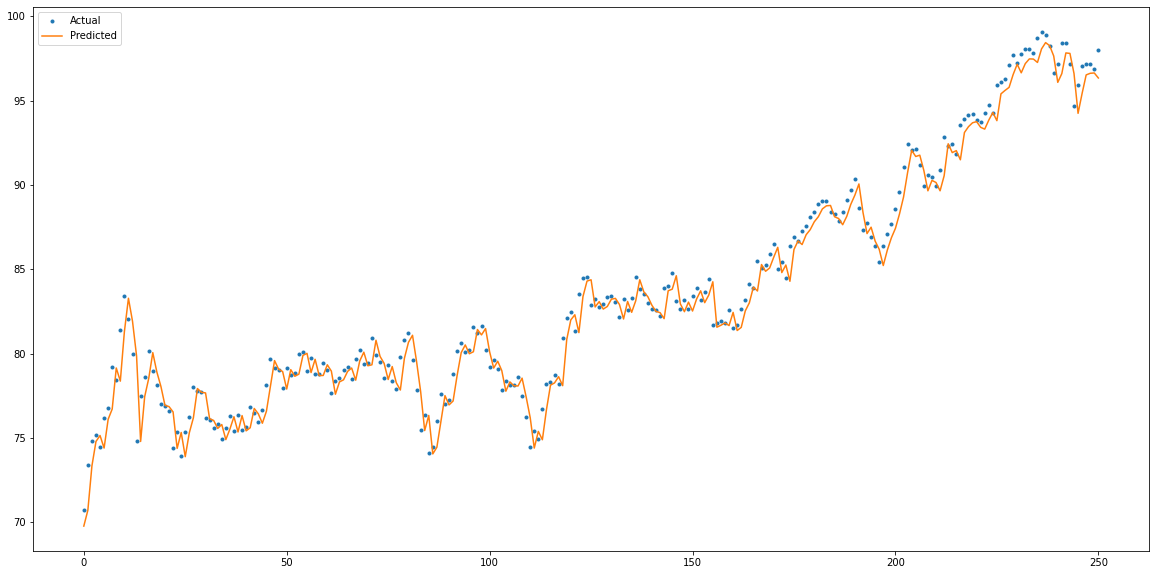

In [29]:
plot_prediction(base_y_val_true, base_y_val_inv)

- Compare the train and val r^2, no sign of overfitting

## Tuning Steps
- Timestep changing
- Increase the depth of the LSTM
- Pretrained network

### a)Time Steps

#### timestep = 5 days

In [34]:
# X,y split with timestep of 5
X_train_5, y_train_5 = xy_split(train_scale, timestep=5)
X_val_5, y_val_5 = xy_split(val_scale, timestep=5)

In [35]:
# Build the model
t5_model = Sequential()
t5_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:])))
t5_model.add(LSTM(50))
t5_model.add(Dense(units=1))

# Compile the model
t5_model.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
# Model Checkpoint
mc_t5 = ModelCheckpoint(filepath='/content/t5_u50.h5',
                        monitor='val_loss', mode='min', verbose=0, save_best_only=True)

In [39]:
# Fit the model
t5_model.fit(X_train_5, y_train_5, batch_size=23, epochs=50,
             validation_data=(X_val_5, y_val_5),
             callbacks=[es, mc_t5],
             verbose=0)

In [41]:
t5_y_val_true, t5_y_val_inv = model_evaluation(t5_model, X_train_5, y_train_5, X_val_5, y_val_5)

Train results: 
MAE: 0.7534
RMSE: 1.1503
R^2: 0.9962
None


Val results: 
MAE: 1.3773
RMSE: 1.7201
R^2: 0.9359
None


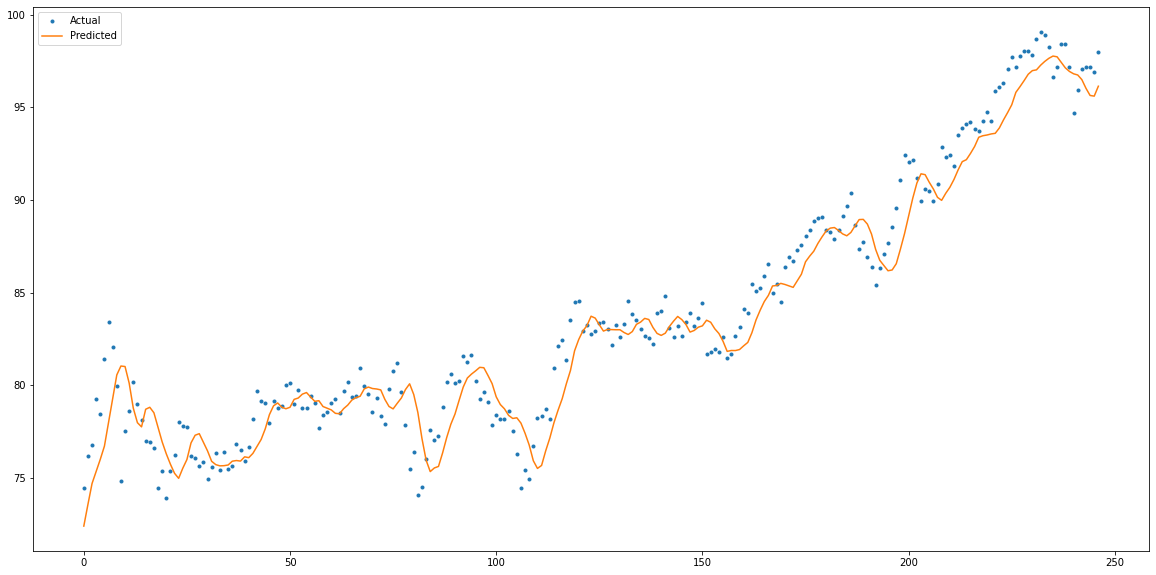

In [42]:
plot_prediction(t5_y_val_true, t5_y_val_inv)

#### timestep = 21 days

In [51]:
# X,y split with timestep of 21
X_train_21, y_train_21 = xy_split(train_scale, timestep=21)
X_val_21, y_val_21 = xy_split(val_scale, timestep=21)

In [52]:
# Build the model
t21_model = Sequential()
t21_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:])))
t21_model.add(LSTM(units=50))
t21_model.add(Dense(units=1))

# Compile the model
t21_model.compile(optimizer='adam', loss='mean_squared_error')

In [53]:
# Model Checkpoint
mc_t21 = ModelCheckpoint(filepath='/content/t21_u50.h5',
                         monitor='val_loss', mode='min', verbose=0, save_best_only=True)

In [56]:
# Fit the model
t21_model.fit(X_train_21, y_train_21, batch_size=23, epochs=50,
             validation_data=(X_val_21, y_val_21),
             callbacks=[es, mc_t21],
             verbose=0)

In [58]:
t21_y_val_true, t21_y_val_inv = model_evaluation(t21_model, X_train_21, y_train_21, X_val_21, y_val_21)

Train results: 
MAE: 0.9217
RMSE: 1.2905
R^2: 0.9952
None


Val results: 
MAE: 1.3687
RMSE: 1.7071
R^2: 0.9380
None


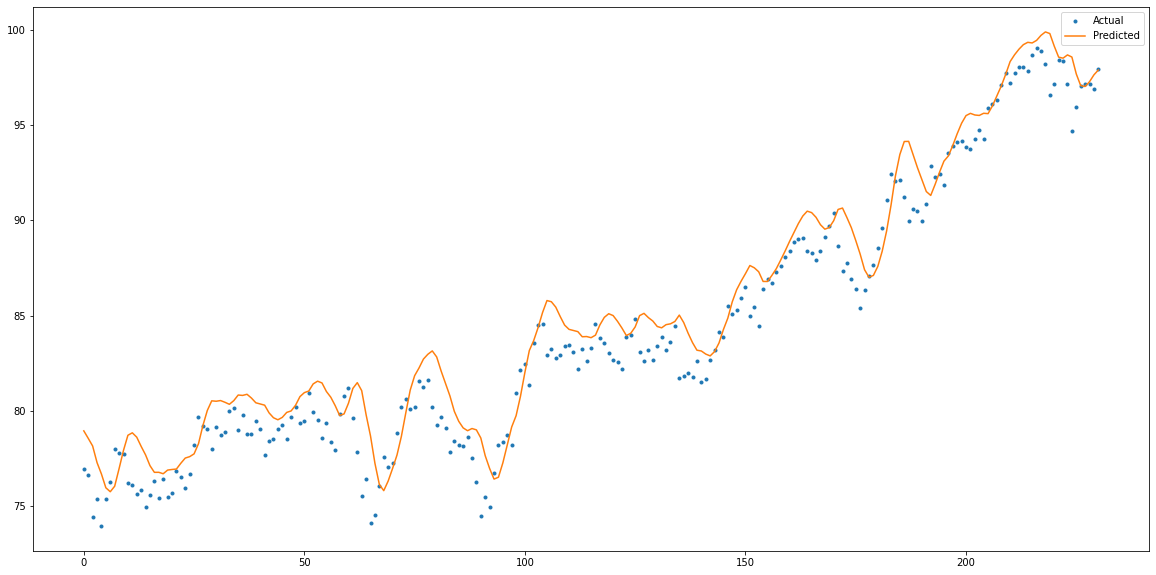

In [59]:
plot_prediction(t21_y_val_true, t21_y_val_inv)

>**Comment:** *Time step*
- Increase the time step makes the model less predictable

- Batch size controls how often to update the weights
- Epoch defines the number times that the learning algorithm will work through the entire training dataset

https://github.com/tirthajyoti/Deep-learning-with-Python/blob/master/Notebooks/Keras_Scikit_Learn_wrapper.ipynb

https://towardsdatascience.com/are-you-using-the-scikit-learn-wrapper-in-your-keras-deep-learning-model-a3005696ff38

### b) Input Features

#### Grid Search

In [60]:
def feature_model(features):
    '''
    Create a LSTM model with custom input features.

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - fetures: integer

    Return:
    - Custom model
    '''

    # Build the model
    model = Sequential()
    model.add(LSTM(units=features, return_sequences=True, input_shape=(X_train.shape[1:])))
    model.add(LSTM(units=features))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
  
    return model

In [61]:
# Wrapper
f_model = KerasRegressor(build_fn=feature_model)

In [62]:
# Input features
f = [50, 100, 150, 200, 250, 300]

# Parameter grid
f_param_grid = dict(features = f)

In [63]:
# Grid Search
f_grid = GridSearchCV(f_model, param_grid = f_param_grid, cv=3)

In [67]:
f_grid_history = f_grid.fit(X_train, y_train,
                            batch_size=23, epochs=50,
                            validation_data=(X_val, y_val),
                            callbacks=es,
                            verbose=1)

Epoch 1/50
115/115 [==============================] - 4s 11ms/step - loss: 0.0936 - val_loss: 0.0201
Epoch 2/50
115/115 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 3/50
115/115 [==============================] - 1s 5ms/step - loss: 9.9404e-04 - val_loss: 4.6155e-04
Epoch 4/50
115/115 [==============================] - 0s 4ms/step - loss: 2.9581e-04 - val_loss: 7.3395e-04
Epoch 5/50
115/115 [==============================] - 1s 5ms/step - loss: 2.7817e-04 - val_loss: 8.9029e-04
Epoch 6/50
115/115 [==============================] - 1s 5ms/step - loss: 2.6239e-04 - val_loss: 5.1688e-04
Epoch 7/50
115/115 [==============================] - 1s 5ms/step - loss: 2.5565e-04 - val_loss: 6.7740e-04
Epoch 8/50
115/115 [==============================] - 0s 4ms/step - loss: 2.3104e-04 - val_loss: 7.4618e-04
Epoch 9/50
115/115 [==============================] - 0s 4ms/step - loss: 2.2002e-04 - val_loss: 6.9598e-04
Epoch 00009: early stopping
41/41 [========

In [82]:
# Find the best parameter
f_grid_history.best_params_

{'features': 250}

In [93]:
# Number of features
n_features = f_grid_history.best_params_['features']
n_features

250

#### input features = 250

In [74]:
model_f250 = feature_model(250)

In [72]:
mc_f250 = ModelCheckpoint(filepath='/content/f250.h5',
                            monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [75]:
model_f250.fit(X_train, y_train, batch_size=23, epochs=50,
           validation_data=(X_val, y_val),
           callbacks=[es, mc_f250])

Epoch 1/50
172/172 [==============================] - 6s 17ms/step - loss: 0.0187 - val_loss: 4.2822e-04

Epoch 00001: val_loss did not improve from 0.00017
Epoch 2/50
172/172 [==============================] - 2s 13ms/step - loss: 1.4379e-04 - val_loss: 3.1240e-04

Epoch 00002: val_loss did not improve from 0.00017
Epoch 3/50
172/172 [==============================] - 2s 13ms/step - loss: 1.2431e-04 - val_loss: 2.2782e-04

Epoch 00003: val_loss did not improve from 0.00017
Epoch 4/50
172/172 [==============================] - 2s 12ms/step - loss: 1.1266e-04 - val_loss: 3.1896e-04

Epoch 00004: val_loss did not improve from 0.00017
Epoch 5/50
172/172 [==============================] - 2s 12ms/step - loss: 1.0053e-04 - val_loss: 2.1637e-04

Epoch 00005: val_loss did not improve from 0.00017
Epoch 6/50
172/172 [==============================] - 2s 12ms/step - loss: 9.6329e-05 - val_loss: 1.9675e-04

Epoch 00006: val_loss did not improve from 0.00017
Epoch 7/50
172/172 [==================

In [77]:
f250 = load_model('/content/f250.h5')

In [78]:
f250_y_val_true, f250_y_val_inv = model_evaluation(f250, X_train, y_train, X_val, y_val)

Train results: 
MAE: 0.4892
RMSE: 0.7644
R^2: 0.9983
None


Val results: 
MAE: 0.8244
RMSE: 1.0673
R^2: 0.9758
None


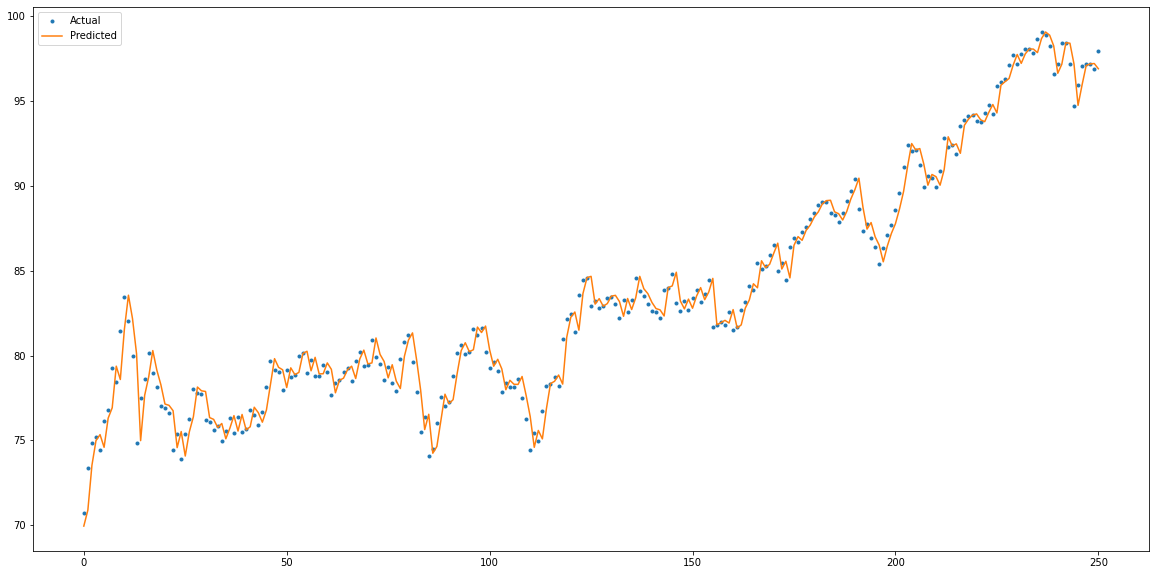

In [79]:
plot_prediction(f250_y_val_true, f250_y_val_inv)

In [89]:
# Load model (if run in another notebook)
best = load_model('/content/f250.h5')

In [90]:
# Make prediction on the holdout test set
y_test_pred = best.predict(X_test)

# Inverse transform the test prediction and actual
y_test_inv = scaler.inverse_transform(y_test_pred)
y_test_true = scaler.inverse_transform(y_test)

In [91]:
ut.evaluate(y_test_true, y_test_inv)

MAE: 0.7419
RMSE: 0.9534
R^2: 0.7756


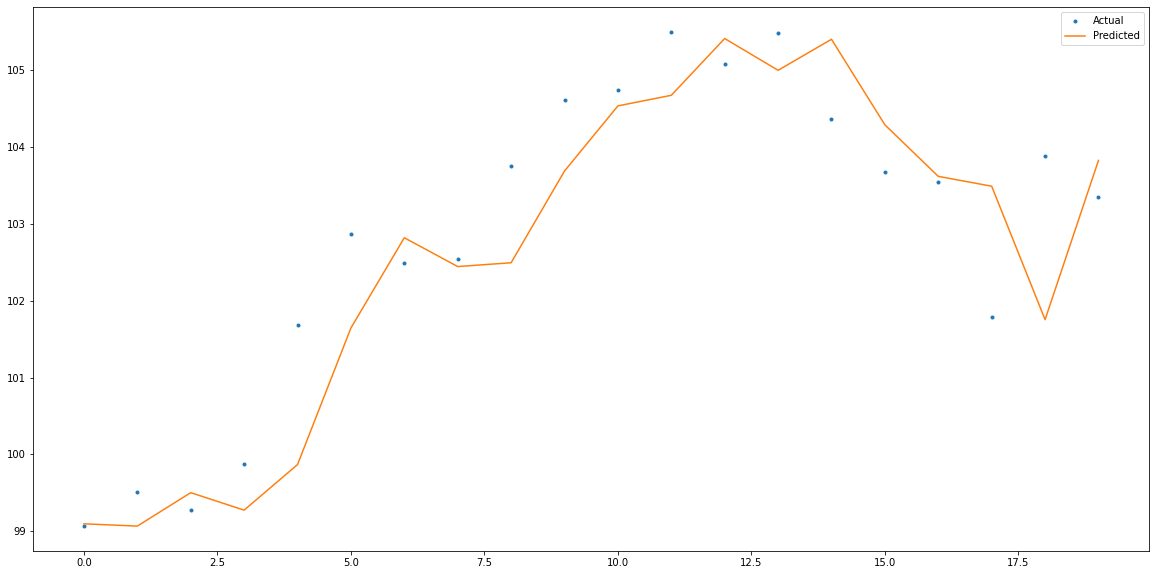

In [92]:
plot_prediction(y_test_true, y_test_inv)

### c) Layers

In [130]:
def stack_model(layers):
    '''
    Create a LSTM with custom hidden layers.
    
    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - layers: interger (number of hidden layers)
    
    Return:
    - Custome model

    '''
    if layers == 2:
        # Build the model
        model = Sequential()
        model.add(LSTM(units=n_features, return_sequences=True, input_shape=(X_train.shape[1:])))
        model.add(LSTM(units=n_features))
        model.add(Dense(units=1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
    
        return model
    
    elif layers == 3:
        # Build the model
        model = Sequential()
        model.add(LSTM(units=n_features, return_sequences=True, input_shape=(X_train.shape[1:])))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features))
        model.add(Dense(units=1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
    
        return model
    
    elif layers == 4:
        # Build the model
        model = Sequential()
        model.add(LSTM(units=n_features, return_sequences=True, input_shape=(X_train.shape[1:])))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features))
        model.add(Dense(units=1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
    
        return model
    
    elif layers == 5:
        # Build the model
        model = Sequential()
        model.add(LSTM(units=n_features, return_sequences=True, input_shape=(X_train.shape[1:])))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features, return_sequences=True))
        model.add(LSTM(units=n_features))
        model.add(Dense(units=1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
    
        return model
    
    else:
        print("Please select number of layers betweeen 2 to 5.")

#### Grid Search

In [131]:
# Wrapper
s_model = KerasRegressor(build_fn=stack_model)

In [132]:
s = [2, 3, 4, 5]

# Parameter grid
s_param_grid = dict(layers = s)

In [133]:
# Grid Search
s_grid = GridSearchCV(s_model, param_grid = s_param_grid, cv=3)

In [135]:
s_grid_history = s_grid.fit(X_train, y_train,
                            batch_size=23, epochs=50,
                            validation_data=(X_val, y_val),
                            callbacks=es,
                            verbose=0)

Epoch 00028: early stopping
41/41 [==============================] - 1s 5ms/step - loss: 7.5740e-05
Epoch 00017: early stopping
41/41 [==============================] - 1s 5ms/step - loss: 1.0963e-04
Epoch 00017: early stopping
41/41 [==============================] - 1s 5ms/step - loss: 1.8725e-04
Epoch 00021: early stopping
41/41 [==============================] - 1s 7ms/step - loss: 7.3554e-05
Epoch 00012: early stopping
41/41 [==============================] - 1s 7ms/step - loss: 3.8706e-05
Epoch 00016: early stopping
41/41 [==============================] - 1s 8ms/step - loss: 7.4122e-04
Epoch 00015: early stopping
41/41 [==============================] - 2s 9ms/step - loss: 1.1369e-04
Epoch 00016: early stopping
41/41 [==============================] - 2s 9ms/step - loss: 1.1148e-04
Epoch 00011: early stopping
41/41 [==============================] - 2s 9ms/step - loss: 4.4535e-04
Epoch 00011: early stopping
41/41 [==============================] - 2s 11ms/step - loss: 7.2808e-05

In [136]:
s_grid_history.best_params_

{'layers': 2}

https://stackoverflow.com/questions/46713734/are-there-some-pre-trained-lstm-rnn-or-ann-models-for-time-series-prediction

### Evaluation
- Prediction on true holdout test set

In [137]:
# Load model (if run in another notebook)
best = load_model('/content/f250.h5')

In [138]:
# Make prediction on the holdout test set
y_test_pred = best.predict(X_test)

# Inverse transform the test prediction and actual
y_test_inv = scaler.inverse_transform(y_test_pred)
y_test_true = scaler.inverse_transform(y_test)

In [139]:
ut.evaluate(y_test_true, y_test_inv)

MAE: 0.7419
RMSE: 0.9534
R^2: 0.7756


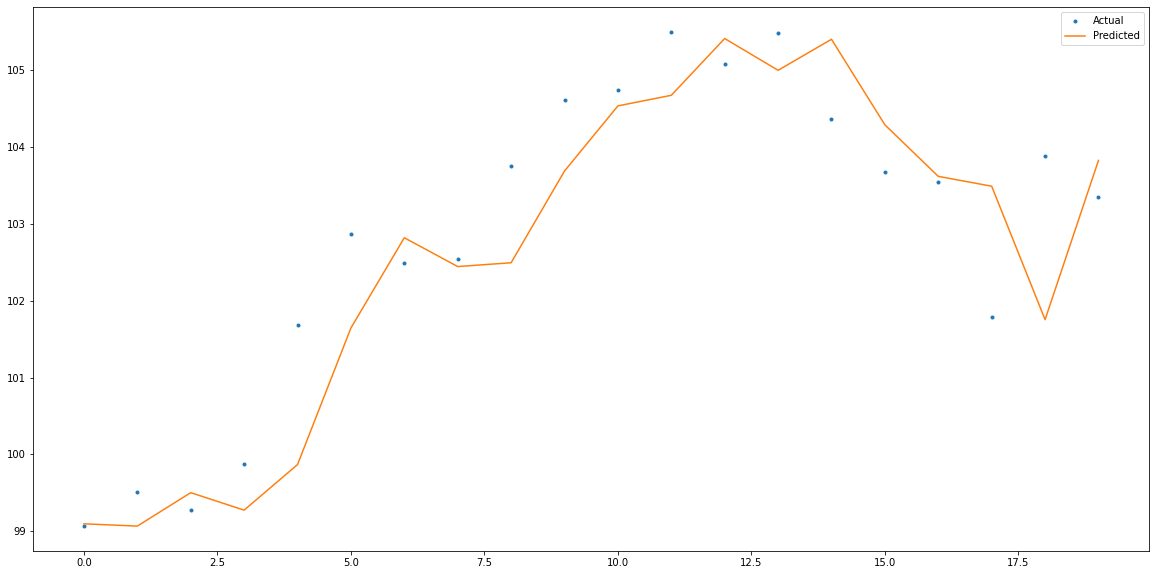

In [140]:
plot_prediction(y_test_true, y_test_inv)